In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
pd.options.display.float_format = '{:,.2f}'.format

from itertools import product

import matplotlib.pyplot as plt

import bamboolib as bam
#bam.enable()

bam.disable()

The bamboolib extension was disabled. You can enable it again via 'bam.enable()'. In case that bamboolib was not helpful to you, we are sorry and would like to fix this. Please write us a quick mail to info@8080labs.com so that we can serve you better in the future. Best regards, Tobias and Florian


In [2]:
list_column_keep_2010 = [
    'CBO Ocupação 2002'
    , 'CNAE 2.0 Classe'
    , 'CNAE 95 Classe'
    , 'Vínculo Ativo 31/12'
    , 'Faixa Etária'
    , 'Faixa Remun Dezem (SM)'
    , 'Faixa Remun Média (SM)'
    , 'Faixa Tempo Emprego'
    , 'Escolaridade após 2005'
    , 'Mun Trab'
    , 'Município'
    , 'Nacionalidade'
    , 'Natureza Jurídica'
    , 'Vl Remun Dezembro Nom'
    , 'Vl Remun Dezembro (SM)'
    , 'Vl Remun Média Nom'
    , 'Vl Remun Média (SM)'
    , 'CNAE 2.0 Subclasse'
    , 'Tamanho Estabelecimento'
    , 'Tipo Estab'
    , 'Tipo Estab.1'
    , 'Tipo Vínculo'
]

type_cat_tam_estabelecimento = CategoricalDtype(categories=[ -1, 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], ordered=True)
type_cat_escolaridade = CategoricalDtype(categories=[ -1, 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], ordered=True)
type_cat_faixa_etaria = CategoricalDtype(categories=['01', '02', '03', '04', '05', '06', '07', '08'], ordered=True)
type_cat_faixa_remu_media = CategoricalDtype(
    categories=[
        '00'
        ,'01'
        , '02'
        , '03'
        , '04'
        , '05'
        , '06'
        , '07'
        , '08'
        , '09'
        , '10'
        , '11'
    ]
    , ordered=True
)

type_cat_faixa_remu_media_dezembro = CategoricalDtype(
    categories=[
        '00'
        , '01'
        , '02'
        , '03'
        , '04'
        , '05'
        , '06'
        , '07'
        , '08'
        , '09'
        , '10'
        , '11'
        , '12'
    ]
    , ordered=True
)

type_cat_ind_tec = CategoricalDtype(
    categories=[
        'High-technology'
        , 'Medium-high-technology'
        , 'Medium-low-technology'
        , 'Low-technology'
        , 'Without Classification'
    ]
    , ordered=True
)


type_cat_know_services = CategoricalDtype(
    categories=[
        'High-tech knowledge-intensive services'
        , 'Knowledge-intensive financial services'
        , 'Knowledge-intensive market services'
        , 'Other knowledge-intensive services'
        , 'Less knowledge-intensive market services'
        , 'Other less knowledge-intensive services'
        , 'Without Classification'
    ]
    , ordered=True
)






dic_dtype = {
    'CBO Ocupação 2002' : 'category'
    ,'CNAE 2.0 Classe' : 'category'
    ,'CNAE 95 Classe' : 'category'
    ,'Faixa Etária' : type_cat_faixa_etaria
    ,'Faixa Remun Dezem (SM)' : type_cat_faixa_remu_media_dezembro
    ,'Faixa Remun Média (SM)' : type_cat_faixa_remu_media
    ,'Faixa Tempo Emprego' : 'category'
    ,'Escolaridade após 2005' : type_cat_escolaridade
    ,'Mun Trab' : 'category'
    ,'Município' : 'category'
    ,'Nacionalidade' : 'category'
    ,'Natureza Jurídica' : 'category'
    ,'CNAE 2.0 Subclasse' : 'category'
    ,'Tamanho Estabelecimento' : type_cat_tam_estabelecimento
    ,'Tipo Estab' : 'category'
    ,'Tipo Estab.1' : 'category'
    ,'Tipo Vínculo' : 'category'
    , 'Vl Remun Dezembro Nom' : np.float64
    , 'Vl Remun Média Nom' : np.float32
    , 'Vl Remun Dezembro (SM)' : np.float64
    , 'Vl Remun Média (SM)' : np.float64
    , 'Tempo Emprego' : np.float64
    , 'territorio_tese':'category'
    , 'arranjo':'category'
    , 'knowledge_services':'category'
    , 'technology_industries':type_cat_ind_tec
    , 'potec':'category'
}

In [3]:
def aggregate_knowledge_serv(ufs = ['pr', 'rs', 'pe'], year = [2015]):



    dict_df = dict()

    ufs = tuple([unity.upper() for unity in ufs])

    for uf, year in product(ufs, year):

        df = pd.read_csv(
            f'data/rais_treated/{year}/{uf.upper()}{year}.zip'
            , compression='zip'
            , header=0
            , sep=';'
            , decimal=','
            , dtype=dic_dtype
            , usecols=['territorio_tese', 'knowledge_services']
        )

        filter_services = df.knowledge_services != df.knowledge_services.cat.categories[6]    
        filter_rm_territory = df.territorio_tese != df.territorio_tese.cat.categories[1]

        df_composed = pd.DataFrame(df.loc[filter_services & filter_rm_territory, :].groupby(by=['territorio_tese', 'knowledge_services'], observed=True).size().sort_index())


        df_composed['PO estadual'] = df.loc[filter_services,:].groupby(by=['knowledge_services'], observed=True).count().sort_index().values

        df_composed.rename(columns={0:'PO Metropolitano'}, inplace=True)

        df_composed['Participação do setor no espaço metropolitano (%)'] = df_composed['PO Metropolitano'] / df_composed['PO Metropolitano'].sum() *100

        df_composed['Participação do espaço metropolitano no estado (%)'] = df_composed['PO Metropolitano'] / df_composed['PO estadual'] *100

        dict_df[uf] = df_composed
        
        
    list_dfs = [dict_df[uf].reset_index().drop(columns='territorio_tese').set_index('knowledge_services') for uf in ufs]
    list_keys = [dict_df[uf].index[0][0] for uf in ufs]
    
    df_composed = pd.concat(list_dfs,  axis=0, keys=list_keys)
    
    return df_composed

In [4]:
df = aggregate_knowledge_serv()

In [5]:
df

PO Metropolitano  \
                                     knowledge_services                                           
Espaço Metropolitano de Curitiba     High-tech knowledge-intensive services               28037   
                                     Knowledge-intensive financial services               29920   
                                     Knowledge-intensive market services                  79725   
                                     Less knowledge-intensive market services            436420   
                                     Other knowledge-intensive services                  357303   
                                     Other less knowledge-intensive services              30966   
Espaço Metropolitano de Porto Alegre High-tech knowledge-intensive services               30992   
                                     Knowledge-intensive financial services               28934   
                                     Knowledge-intensive market services                  73953   
                                     Less knowledge-intensive market services            467526   
                                     Other knowledge-intensive services                  410070   
                                     Other less knowledge-intensive services              36831   
Espaço Metropolitano de Recife       High-tech knowledge-intensive services               18545   
                                     Knowledge-intensive financial services               14068   
                                     Knowledge-intensive market services                  84241   
                                     Less knowledge-intensive market services            395114   
                                     Other knowledge-intensive services                  346178   
                                     Other less knowledge-intensive services              30659   

                                                                               PO estadual  \
                                     knowledge_services                                      
Espaço Metropolitano de Curitiba     High-tech knowledge-intensive services          48473   
                                     Knowledge-intensive financial services          57868   
                                     Knowledge-intensive market services            120879   
                                     Less knowledge-intensive market services      1105804   
                                     Other knowledge-intensive services             760596   
                                     Other less knowledge-intensive services         89472   
Espaço Metropolitano de Porto Alegre High-tech knowledge-intensive services          47525   
                                     Knowledge-intensive financial services          58000   
                                     Knowledge-intensive market services            113548   
                                     Less knowledge-intensive market services      1026301   
                                     Other knowledge-intensive services             780848   
                                     Other less knowledge-intensive services         67793   
Espaço Metropolitano de Recife       High-tech knowledge-intensive services          21752   
                                     Knowledge-intensive financial services          19818   
                                     Knowledge-intensive market services             94322   
                                     Less knowledge-intensive market services       563309   
                                     Other knowledge-intensive services             558020   
                                     Other less knowledge-intensive services         42012   

                                                                               Participação do setor no espaço metropolitano (%)  \
                                     knowledge_services                              

In [6]:
def knowledge_serv_evolution(ufs = ['pr'], years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]):

    dict_df = dict()

    ufs = tuple([unity.upper() for unity in ufs])

    for uf, year in product(ufs, years):

        df = pd.read_csv(
            f'data/rais_treated/{year}/{uf.upper()}{year}.zip'
            , compression='zip'
            , header=0
            , sep=';'
            , decimal=','
            , dtype=dic_dtype
            , usecols=['territorio_tese', 'knowledge_services']
        )

        filter_services = df.knowledge_services != df.knowledge_services.cat.categories[6]    
        filter_rm_territory = df.territorio_tese != df.territorio_tese.cat.categories[1]
#        filter_uf_territory = df.territorio_tese != df.territorio_tese.cat.categories[0]

        df_derivado = pd.DataFrame(df.loc[filter_services & filter_rm_territory, :].groupby(by=['territorio_tese', 'knowledge_services'], observed=True).size())


    #    df_derivado['PO estadual'] = np.array(df.loc[filter_industry, :].groupby(by=['technology_industries'], observed=True).size())

        df_derivado.rename(columns={0:'PO Metropolitano'}, inplace=True)

    #    df_derivado['Participação do setor no espaço metropolitano (%)'] = df_derivado['PO Metropolitano'] / df_derivado['PO Metropolitano'].sum() *100

    #    df_derivado['Participação do espaço metropolitano no estado (%)'] = df_derivado['PO Metropolitano'] / df_derivado['PO estadual'] *100

        dict_df[uf + str(year)] = df_derivado

    list_dfs = [dict_df[uf + str(year)].reset_index().drop(columns='territorio_tese').set_index('knowledge_services') 
     for uf, year in product(ufs, years)]
    
    df_derivado = pd.concat(list_dfs,  axis=1)
    
    df_derivado.columns = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
    
    
    return df_derivado


    #pd.concat([dict_df[ufs[0]].reset_index().drop(columns='territorio_tese').set_index('technology_industries')
    #           , dict_df[ufs[1]].reset_index().drop(columns='territorio_tese').set_index('technology_industries')
    #           , dict_df[ufs[2]].reset_index().drop(columns='territorio_tese').set_index('technology_industries')]
    #          ,  axis=0
    #          , keys=[dict_df[ufs[0]].index[0][0], dict_df[ufs[1]].index[0][0], dict_df[ufs[2]].index[0][0]])

In [7]:
df_pr = knowledge_serv_evolution()

In [10]:
df_rs = knowledge_serv_evolution(ufs=['rs'])

In [11]:
df_pe = knowledge_serv_evolution(ufs=['pe'])

In [13]:
df_aggregated  = pd.concat([df_pr, df_rs, df_pe], keys=['Curitiba', 'Porto Alegre', 'Recife'])

In [14]:
df_aggregated

2007    2008    2009  \
             knowledge_services                                                 
Curitiba     High-tech knowledge-intensive services     16963   18294   18926   
             Knowledge-intensive financial services     25735   26105   26324   
             Knowledge-intensive market services        51660   52228   62488   
             Less knowledge-intensive market services  331759  349038  363829   
             Other knowledge-intensive services        285296  296046  335609   
             Other less knowledge-intensive services    35013   34995   36125   
Porto Alegre High-tech knowledge-intensive services     17572   19566   20586   
             Knowledge-intensive financial services     33776   32572   26382   
             Knowledge-intensive market services        53772   55858   58868   
             Less knowledge-intensive market services  350793  377963  396538   
             Other knowledge-intensive services        363683  363223  373483   
             Other less knowledge-intensive services    36579   38214   38997   
Recife       High-tech knowledge-intensive services      9267    9530    9906   
             Knowledge-intensive financial services     13213   13861   13680   
             Knowledge-intensive market services        56397   61900   74168   
             Less knowledge-intensive market services  268098  287519  302515   
             Other knowledge-intensive services        276482  285849  300055   
             Other less knowledge-intensive services    26717   25853   26416   

                                                         2010    2011    2012  \
             knowledge_services                                                 
Curitiba     High-tech knowledge-intensive services     23709   28406   29525   
             Knowledge-intensive financial services     27470   28270   26415   
             Knowledge-intensive market services        68867   71729   76643   
             Less knowledge-intensive market services  387128  409595  429826   
             Other knowledge-intensive services        315366  330976  376654   
             Other less knowledge-intensive services    34604   34623   32500   
Porto Alegre High-tech knowledge-intensive services     22333   24306   29122   
             Knowledge-intensive financial services     24784   27888   28483   
             Knowledge-intensive market services        73940   74848   78722   
             Less knowledge-intensive market services  428284  444564  462034   
             Other knowledge-intensive services        380217  383289  397660   
             Other less knowledge-intensive services    39574   40354   39251   
Recife       High-tech knowledge-intensive services     11756   13258   15097   
             Knowledge-intensive financial services     14595   15912   13625   
             Knowledge-intensive market services        80868   79126   99451   
             Less knowledge-intensive market services  337482  368733  396527   
             Other knowledge-intensive services        314620  336065  327226   
             Other less knowledge-intensive services    29289   29296   31115   

                                                         2013    2014    2015  
             knowledge_services                                                
Curitiba     High-tech knowledge-intensive services     28309   28251   28037  
             Knowledge-intensive financial services     28206   29311   29920  
             Knowledge-intensive market services        80327   81232   79725  
             Less knowledge-intensive market services  439361  448331  436420  
             Other knowledge-intensive services        354086  356210  357303  
             Other less knowledge-intensive services    31152   29267   30966  
Porto Alegre High-tech knowledge-intensive services     30062   31626   30992  
             Knowledge-intensive financial services     28809   29092   28934  
             Kn

In [169]:
legenda = df_aggregated.index[1][0] + '-' + df_aggregated.index[1][1]

No gráfico abaixo, quero colocar um subplot só com o comportamento da alta tecnologia

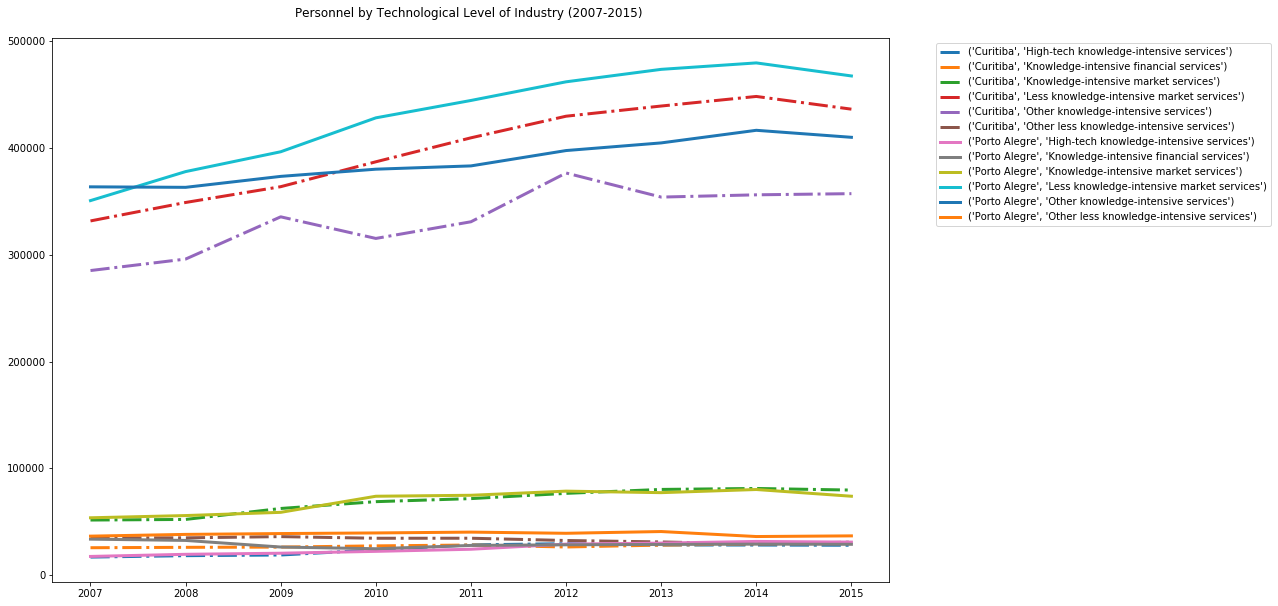

In [15]:
linestyles = ['-.','-.', '-.', '-.', '-.', '-.', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dotted', 'dotted', 'dotted', 'dotted', 'dotted', 'dotted']

linecolors = ['#274E13','#38761D','#6AA84F','#93C47D', '#B45F06','#cb8934','#dba452','#FFE599','#351C75','#674EA7','#8E7CC3','#B4A7D6']

plt.figure(figsize=(15,10))
for i, linestyle, color in zip(range(len(df_aggregated.index)), linestyles, linecolors):
    plt.plot(df_aggregated.loc[df_aggregated.index[i]], linestyle=linestyle, linewidth=3)
plt.legend(df_aggregated.index,  loc='upper left', bbox_to_anchor=(1.05, 1));
plt.title('Personnel by Technological Level of Industry (2007-2015) \n');

In [16]:
#### df_aggregated['2007 a 2009 (%)'] = ((df_aggregated[2009] / df_aggregated[2007] - 1) * 100).values
df_aggregated['2009 a 2011 (%)'] = ((df_aggregated[2011] / df_aggregated[2009] - 1) * 100).values
df_aggregated['2011 a 2013 (%)'] = ((df_aggregated[2013] / df_aggregated[2011] - 1) * 100).values
df_aggregated['2013 a 2015 (%)'] = ((df_aggregated[2015] / df_aggregated[2013] - 1) * 100).values

df_aggregated

2007    2008    2009  \
             knowledge_services                                                 
Curitiba     High-tech knowledge-intensive services     16963   18294   18926   
             Knowledge-intensive financial services     25735   26105   26324   
             Knowledge-intensive market services        51660   52228   62488   
             Less knowledge-intensive market services  331759  349038  363829   
             Other knowledge-intensive services        285296  296046  335609   
             Other less knowledge-intensive services    35013   34995   36125   
Porto Alegre High-tech knowledge-intensive services     17572   19566   20586   
             Knowledge-intensive financial services     33776   32572   26382   
             Knowledge-intensive market services        53772   55858   58868   
             Less knowledge-intensive market services  350793  377963  396538   
             Other knowledge-intensive services        363683  363223  373483   
             Other less knowledge-intensive services    36579   38214   38997   
Recife       High-tech knowledge-intensive services      9267    9530    9906   
             Knowledge-intensive financial services     13213   13861   13680   
             Knowledge-intensive market services        56397   61900   74168   
             Less knowledge-intensive market services  268098  287519  302515   
             Other knowledge-intensive services        276482  285849  300055   
             Other less knowledge-intensive services    26717   25853   26416   

                                                         2010    2011    2012  \
             knowledge_services                                                 
Curitiba     High-tech knowledge-intensive services     23709   28406   29525   
             Knowledge-intensive financial services     27470   28270   26415   
             Knowledge-intensive market services        68867   71729   76643   
             Less knowledge-intensive market services  387128  409595  429826   
             Other knowledge-intensive services        315366  330976  376654   
             Other less knowledge-intensive services    34604   34623   32500   
Porto Alegre High-tech knowledge-intensive services     22333   24306   29122   
             Knowledge-intensive financial services     24784   27888   28483   
             Knowledge-intensive market services        73940   74848   78722   
             Less knowledge-intensive market services  428284  444564  462034   
             Other knowledge-intensive services        380217  383289  397660   
             Other less knowledge-intensive services    39574   40354   39251   
Recife       High-tech knowledge-intensive services     11756   13258   15097   
             Knowledge-intensive financial services     14595   15912   13625   
             Knowledge-intensive market services        80868   79126   99451   
             Less knowledge-intensive market services  337482  368733  396527   
             Other knowledge-intensive services        314620  336065  327226   
             Other less knowledge-intensive services    29289   29296   31115   

                                                         2013    2014    2015  \
             knowledge_services                                                 
Curitiba     High-tech knowledge-intensive services     28309   28251   28037   
             Knowledge-intensive financial services     28206   29311   29920   
             Knowledge-intensive market services        80327   81232   79725   
             Less knowledge-intensive market services  439361  448331  436420   
             Other knowledge-intensive services        354086  356210  357303   
             Other less knowledge-intensive services    31152   29267   30966   
Porto Alegre High-tech knowledge-intensive services     30062   31626   30992   
             Knowledge-intensive financial services     28809   29092   28934   
     